In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.devices.experimental import TestDevicePythonSim, TestDeviceMPSSim

import matplotlib.pyplot as plt
from time import time

# Intro
In principle one should be able to use this MPS simulator as a black box without any detailed knowledge of its inner workings.  
The simulator works very similarily to the PennyLane simulators: an internal classical state is stored, and each gate corresponds to an action on that state.  
In the case of ``default.qubit`` or ``lightning.qubit`` that state is a $2^L$ component complex vector, and a gate is a $2^L \times 2^L$ unitary matrix.  
Here, the state is represented by a matrix product state (MPS), an efficient representation of low- to intermediate entangled quantum states stored in a  
polynomial number of coefficients ($L\chi^2d$ for $L$ qubits with bond dimension $\chi$ and local Hilbert space dimension $d=2$).  
For higher entangled states, the MPS can serve as an approximation, controlled by a hyper parameter $\chi$, the so-called bond dimension.  
The action of a gate is representated by contracting the MPS with the matrix of the operation and restoring the MPS form. This can be done efficiently for an MPS.

So in principle all a user needs to know is: bond dimension $\chi$ bigger $\Rightarrow$ more faithful representation of the underlyding quantum state.

Feel free to skip the following sub-section if you already know about MPS or dont care and just want to simulate 50 qubits on your Laptop

## Brief intro to MPS and the internal workings of this simulator prototype

The mps simulator works by keeping a matrix product state (mps) as the internal state. Applying gates amounts to contracting and splitting tensors as illustrated below.

<img src="mps_sim_illustration.png" alt= "mps_sim_illustration.png" width="50%" height="50%">

Every time we apply an entanglement generating gate onto the MPS, we perform a compression. We do this by performing a singular value decomposition but keeping only the $\chi$ largest singular values and throwing away all the others. This technique can be used to for example compress images, but it also works well for matrix product states. In the illustration below, only the 3 largest singular values and corresponding left- and right-eigenvectors are kept, still well-approximating the matrix M. We do an explicit example below, or you can go see e.g. [2210.11130 chapter 2: Introduction to tensor network methods](https://arxiv.org/abs/2210.11130) for details.

<img src="svd_illustration.png" alt= "svd_illustration.png" width="50%" height="50%">

What does this mean? In general, one can decompose via the singular value decomposition any matrix $M = U S V^\dagger$ into a left-orthogonal matrix $U$ and right-orthogonal matrix $V^\dagger$. The real-positive singular values are stored on the diagonal matrix $S$, and can be thought of as something like the generalized eigenvalues of a matrix (that may even be rectangular). One can compress any matrix by keeping only the largest, most relevant singular values.  

As an example we draw a circle in an "image" (=Matrix) and compress it

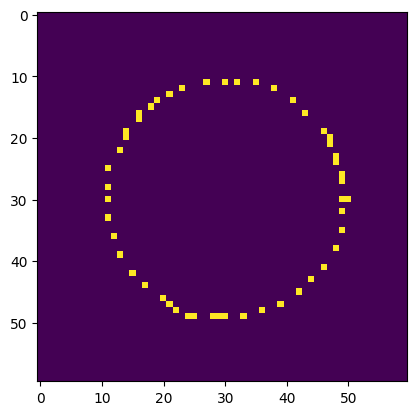

In [2]:
# poorly drawn circle
M = np.zeros((60, 60))
for t in np.linspace(0, 100):
    M[30+int(20*np.sin(t)), 30+int(20*np.cos(t))] = 1
plt.imshow(M)

We can now compute the singular value decomposition of M. We see that most of the singular values are actually zero, meaning that it is not necessary to store all ``60x60`` values of the matrix. Instead we can keep only the non-zero ones:

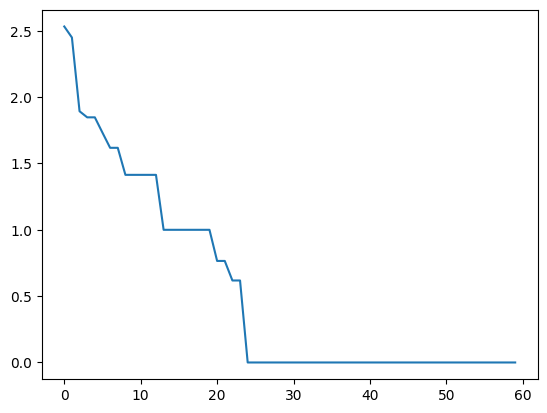

In [3]:
U, S, Vd = np.linalg.svd(M, full_matrices=False)
plt.plot(S)

In [4]:
print(" sizes before compression: ", U.shape, S.shape, Vd.shape)
select = np.max(np.where(S > 1e-14))
U, S, Vd = U[:, :select], S[:select], Vd[:select, :]
print(" sizes after compression: ", U.shape, S.shape, Vd.shape)

 sizes before compression:  (60, 60) (60,) (60, 60)
 sizes after compression:  (60, 23) (23,) (23, 60)


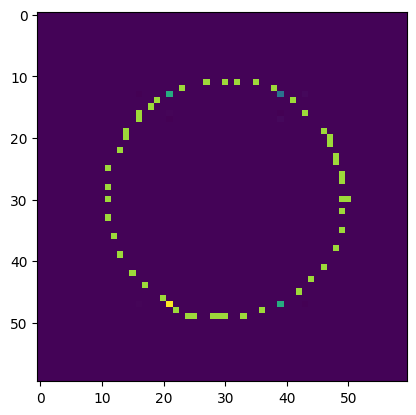

In [5]:
compressed_M = U @ np.diag(S) @ Vd
plt.imshow(compressed_M)

We can go further and only keep the 10 largest singular values (and respective left- and right-singular vectors)

In [6]:
U, S, Vd = U[:, :10], S[:10], Vd[:10, :]
print(" sizes after fixed bond dimension compression: ", U.shape, S.shape, Vd.shape)

 sizes after fixed bond dimension compression:  (60, 10) (10,) (10, 60)


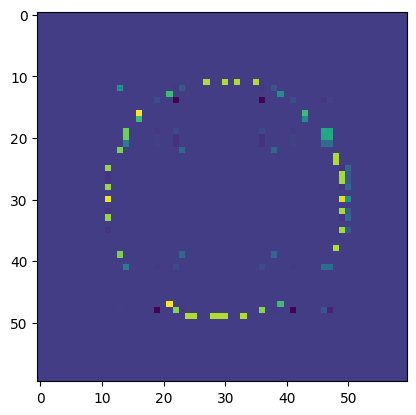

In [7]:
compressed_M = U @ np.diag(S) @ Vd
plt.imshow(compressed_M)

In the case of matrix product state, this is the underlyding principle of compressing the state.  
I.e., we only keep the most relevant coefficients of the matrices that describe the state.  
There is a direct physical interpretation of this: the bonds between sites characterize the von Neumann entropy.  
By enforcing a fixed bond dimension and saying the bonds cannot be larger than $\chi$, we implicitly enforce that  
the bi-partite entanglement of that bond can be at most $\log_2(\chi)=\text{const.}$

Whenever we throw away too much of the singular values (the so-called entanglement sprectrum), our simulation becomes unfaithful. So we have a quantitative measure of the faithfullness of our simulation by keeping track of the truncation error and we need to make sure our bond dimension is chosen large enough to accomodate enough entanglement.  

**Rule of thumb is: The deeper the circuit, the more entanglement, the more bond dimension is required.**

In practice, as we see below in the second-to-last section, one simply performs the simulation with few values of $\chi$ and checks whether the resulting value has converged.

For debugging and curiosity, we can also output a state in form of an MPS:

In [8]:
dev = TestDeviceMPSSim()

L = 50 # note how easily we can simulate 50 qubits with shallow circuits
ops = []
depth = 4
for _ in range(depth):
    a = 2*np.pi*np.random.rand(L)
    b = 2*np.pi*np.random.rand(L)
    ops += [qml.RX(a[i], i) for i in range(L)]
    ops += [qml.RY(b[i], i) for i in range(L)]
    ops += [qml.CNOT((i, i+1)) for i in range(0, L-1, 2)]
    ops += [qml.CNOT((i, i+1)) for i in range(1, L-1, 2)]

qs2 = qml.tape.QuantumScript(ops, [qml.state()])
res = dev.execute(qs2, chi_max=100, eps=1e-12) # chi_max is the max bond dimension

The resulting state is in the form of a ``SimpleMPS``, a custom Matrix Product State class with some basic functionality.  
In essence, it stores the 3-legged tensors in a list ``Bs`` which all have the dimension ``(vL, s_i, vR)`` corresponding  
to the virtual bond on the left, the physical index $\sigma_i$ and the virtual bond to the right. 

<img src="MPS_Bs.png" alt= "MPS_Bs.png.png" width="50%" height="50%">

Further, it stores the singular values between these bonds, which are a direct measure of the bipartite entanglement between  
everything that is left and everything that is right of the bond. We can compute the von Neumann entropy for each bond:

Text(0, 0.5, 'von Neumann entanglement entropy (ebits)')

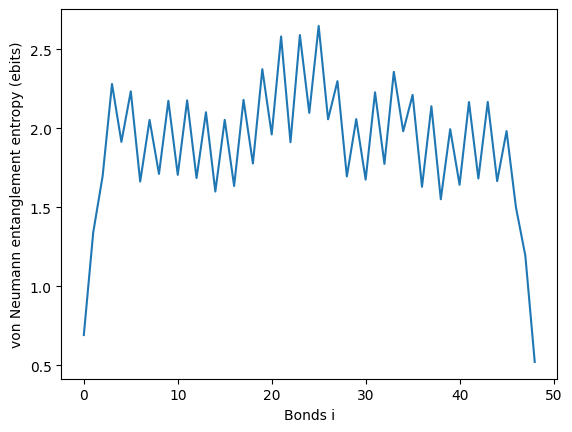

In [9]:
entropies = res.entanglement_entropy()
plt.plot(entropies)
plt.xlabel("Bonds i")
plt.ylabel("von Neumann entanglement entropy (ebits)")

We set the bond dimension to 100 in this example. But as we can see below this is actually not necessary.  
The effective bond dimension of this state is 16, as we can see by looking at the dimension of the matrices or  
singular values of the MPS:

In [10]:
np.max([_.shape for _ in res.Bs]), np.max([_.shape for _ in res.Ss])

(16, 16)

# Device
Continue here if you just want to simulate 50 qubits on your laptop.  
The capabilities of the simulator currently are:
  * Perform arbitrary 1- and 2-site gates (i.e. long-range ``CNOT((1, 10))`` is now possible!)
  * Compute Hamiltonian expectation values

The code of the simulator is neither clean nor optimized, this is merely a proof of concept.  
However, it is quite handy and already doing some useful things!

In [11]:
dev = TestDeviceMPSSim()
dev_check = TestDevicePythonSim()

In [12]:
a = [0.1, 0.2, 0.3]
ops = [qml.RX(a[0], wires=0),
    qml.CNOT(wires=(0,1)),
    qml.RY(a[1], wires=1),
    qml.RZ(a[2], wires=1)]
measurement = qml.expval(qml.PauliX(0) @ qml.PauliX(1))
qs = qml.tape.QuantumScript(ops, [measurement])

dev.execute(qs), dev_check.execute(qs)

(array(0.02950279), 0.02950279191917826)

Currently, the device can compute expectation values of individual local operators, or of `qml.Hamiltonian`s.

In [13]:
L = 50 # note how easily we can simulate 50 qubits with shallow circuits
ops = []
depth = 3
for _ in range(depth):
    a = 2*np.pi*np.random.rand(L)
    b = 2*np.pi*np.random.rand(L)
    ops += [qml.RX(a[i], i) for i in range(L)]
    ops += [qml.RY(b[i], i) for i in range(L)]
    ops += [qml.CNOT((i, i+1)) for i in range(0, L-1, 2)]
    ops += [qml.CNOT((i, i+1)) for i in range(1, L-1, 2)]

H = qml.Hamiltonian(np.random.rand(L-1), [qml.PauliX(i) @ qml.PauliX(i+1) for i in range(L-1)])

qs2 = qml.tape.QuantumScript(ops, [qml.expval(H)])
res = dev.execute(qs2, chi_max=100, eps=1e-12) # chi_max is the bond dimension, eps is the maximum magnitude of singular values to keep (all below are discarded)
res

0.03536356408476839

# Benchmark
In the following, we want to benchmark the MPS simulator with the full state vector simulator in terms of runtime and fidelity.  
For that, we compute the outputs states of random circuits of different sizes and store the runtime as well as the fidelity  
between the full state vector result (taken as the ground truth) and the MPS simulator result.

In [12]:
def mps2vec(state):
    """
    Transform an MPS state into a full vector

    Used for comparing results with full state vector simulations
    """
    Bs = state.Bs
    vec = Bs[0]
    for i in range(1, state.L):
        vec = np.tensordot(vec, Bs[i], 1)
    return vec.reshape(-1)

In [14]:
# This whol benchmark should take around 20 minutes to run on a regular laptop CPU
verbose = False # turn True if you want to see the individual runs and the progress

times = []
times2 = []
fids = []

depth = 10
chi_maxs = [50, 75, 100, 150, 200]
n_wiress = np.arange(5, 25, 1)

for n_wires in n_wiress:
    a = 2*np.pi*np.random.rand(*(depth, 2*n_wires))
    ops = [qml.Hadamard(i) for i in range(n_wires)]
    for k in range(depth):
        ops += [qml.RY(a[k, i], wires=i) for i in range(n_wires)]
        ops += [qml.RX(a[k, i+n_wires], wires=i) for i in range(n_wires)]
        ops += [qml.CNOT((i, i+1)) for i in range(n_wires-1)]

    measurement = [qml.state()]

    qs = qml.tape.QuantumScript(ops, measurement)

    t0 = time()
    res_check = dev_check.execute(qs)
    dt2 = time()-t0
    times2.append(dt2)

    for chi_max in chi_maxs:
        t0 = time()
        res = dev.execute(qs, chi_max=chi_max)
        dt = time()-t0
        times.append(dt)

        vec = mps2vec(res)
        fidelity = np.abs(vec.conj().T @ res_check)
        fids.append(fidelity)

        if verbose:
            print(f"n_wires = {n_wires}, depth = {depth}, chi = {chi_max}, exec time mps: {dt:.5f}, full state {dt2:.5f}")

            if not qml.math.allclose(fidelity, 1):
                print(f"results dont match: F = {fidelity}")

In [15]:
times = np.reshape(times, (len(n_wiress), len(chi_maxs)))
fids = np.reshape(fids, (len(n_wiress), len(chi_maxs)))

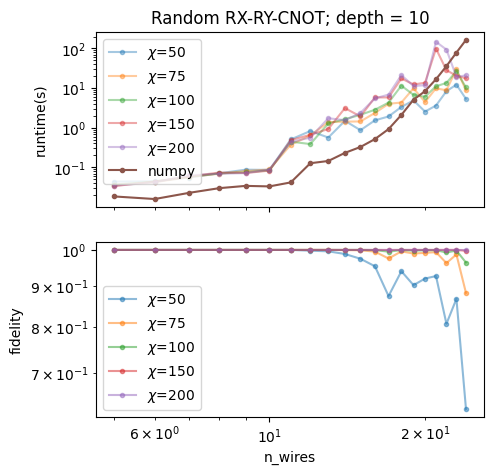

In [16]:
fig, axs = plt.subplots(nrows=2, figsize=(5,5), sharex=True)

ax = axs[0]
for i, chi_max in enumerate(chi_maxs):
    ax.plot(n_wiress, times[:, i], ".-", label=f"$\\chi$={chi_max}", alpha=0.4)
ax.plot(n_wiress, times2, ".-", label="numpy")

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("runtime(s)")
ax.legend()
ax.set_title(f"Random RX-RY-CNOT; depth = {depth}")

ax2 = axs[1]
for i, chi_max in enumerate(chi_maxs):
    ax2.plot(n_wiress, fids[:, i], ".-", label=f"$\\chi$={chi_max}", alpha=0.5)
ax2.set_yscale("log")
ax2.set_ylabel("fidelity")
ax2.legend()
ax2.set_xlabel("n_wires")

plt.savefig("mps-vs-full.png", bbox_inches = 'tight', dpi=500)

We see that for large bond dimension ($\chi \geq 150$) we can faithfully simulate the circuit for 24 qubits at an order magnitude lower runtime.  
More importantly, the MPS simulator is guaranteed to scale polynomially in the number of qubits (vs. exponentially for any state vector simulator).

## Finite size scaling
For <30 qubits we can compare with exact state vector methods to deduce the fidelity. The point of this mps simulator is not to compete with full state vector simulators like lightning, but rather to be able to simulate systems otherwise intractible.

**But when simulating, say, 50 qubits, how do we know if our simulations are faithful?**

Like with real quantum computers, we cant actually be sure. One good indicator, however, is what is called finite size scaling. This is a fancy way of saying that we run the simulation for different bond dimensions and check whether or not the results have converged to a value. If the result remains constant as we increase the bond dimension, it is usually safe to assume that the simulation is faithful in practice.

In the following we simulate the same random 50 qubit circuit for increasing bond dimensions. If the result converges to a fix value, it is a good indicator that the simulation is faithful. This is pure heuristics though, but works well in practice.

Matrix product states offer more advanced means to quantify the faithfullness of the approximation. I.e. the cut-off at each compression when a gate is applied is a direct measure for the approximation error. I have not yet found a nice way to output this from the qnode, though it is no problem in principle.

In [17]:
# this cell should take 15-20 minutes on a Laptop CPU
times = []
ress = []
depths = [5, 7, 9, 11, 13]

for depth in depths:
    n_wires = 50
    chi_maxs = [50, 75, 100, 150, 200]

    np.random.seed(12345)
    a = 2*np.pi*np.random.rand(*(depth, 2*n_wires))
    ops = [qml.Hadamard(i) for i in range(n_wires)]
    for k in range(depth):
        ops += [qml.RY(a[k, i], wires=i) for i in range(n_wires)]
        ops += [qml.RX(a[k, i+n_wires], wires=i) for i in range(n_wires)]
        ops += [qml.CNOT((i, i+1)) for i in range(n_wires-1)]

    measurement = []
    for i in range(n_wires-1):
        measurement.append(qml.expval(qml.PauliX(i) @ qml.PauliX(i+1)))

    for chi_max in chi_maxs:
        qs = qml.tape.QuantumScript(ops, measurement)
        t0 = time()
        res = np.sum(dev.execute(qs, chi_max=chi_max))
        dt = time()-t0

        print(f"chi_max = {chi_max}, res = {res}, exec time mps: {dt:.5f}")

        times.append(dt)
        ress.append(res)

chi_max = 50, res = -0.059808830806669544, exec time mps: 1.41575
chi_max = 75, res = -0.059808830806669544, exec time mps: 0.59013
chi_max = 100, res = -0.059808830806669544, exec time mps: 0.52354
chi_max = 150, res = -0.059808830806669544, exec time mps: 0.59437
chi_max = 200, res = -0.059808830806669544, exec time mps: 0.50973
chi_max = 50, res = 0.04784924210934752, exec time mps: 5.76563
chi_max = 75, res = 0.04798712551934943, exec time mps: 8.00873
chi_max = 100, res = 0.047986288842158234, exec time mps: 7.86396
chi_max = 150, res = 0.047986285133078385, exec time mps: 9.58771
chi_max = 200, res = 0.047986285133078385, exec time mps: 9.26809
chi_max = 50, res = 0.040232629606873696, exec time mps: 16.69964
chi_max = 75, res = 0.0450941121742533, exec time mps: 27.06610
chi_max = 100, res = 0.04795175816580919, exec time mps: 22.82616
chi_max = 150, res = 0.04848664044363243, exec time mps: 35.79469
chi_max = 200, res = 0.04848607924802793, exec time mps: 46.60015
chi_max = 50,

In [18]:
times = np.reshape(times, (len(depths), len(chi_maxs)))
ress = np.reshape(ress, (len(depths), len(chi_maxs)))

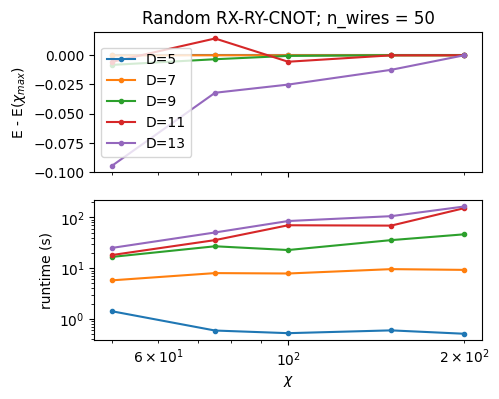

In [19]:
fig, axs = plt.subplots(nrows=2, figsize=(5,4), sharex=True)

ax = axs[0]
ax.set_title(f"Random RX-RY-CNOT; n_wires = {n_wires}")
for i, depth in enumerate(depths):
    ax.plot(chi_maxs, ress[i]-ress[i,-1], ".-", label=f"D={depth}")
ax.legend()
#ax.set_yscale("log")

ax.set_ylabel("E - E($\\chi_{{max}}$)")

ax2 = axs[1]
for i, depth in enumerate(depths):
    ax2.plot(chi_maxs, times[i], ".-", label=f"depth={depth}")
ax.legend(loc=6)
ax2.set_yscale("log")
ax2.set_ylabel("runtime (s)")
ax2.set_xlabel("$\\chi$")
ax2.set_xscale("log")

plt.savefig("mps-finite-size-scaling.png", bbox_inches = 'tight', dpi=500)

All but the $D=13$ runs seem to have converged to a reasonable value. Note that because the parameters are random for every depth, the resulting energies are very different and hence I plot $E(\chi) - E(\chi_\text{max})$.

# Gradient
The simulator allows to compute gradients via the adjoint method. It works the same way as the adjoint method for full state vectors with the difference that overlaps are now between mps and not vectors.

In [20]:
chi_max=20; eps=1e-10
ops = [qml.RY(0.5, wires=0), qml.Identity(1)]
measurement = qml.expval(qml.PauliX(0))
qscript = qml.tape.QuantumScript(ops, [measurement])

In [21]:
dev.execute(qscript), dev_check.execute(qscript)

(array(0.47942554), 0.47942553860420284)

In [22]:
dev.gradient(qscript), dev_check.gradient(qscript)

([array(0.87758256)], [0.8775825618903725])

In [23]:
a = [0.1, 0.2, 0.3]
ops = [qml.RY(a[0], wires=0),
    qml.CNOT(wires=(0,1)),
    qml.RY(a[1], wires=1),
    qml.RZ(a[2], wires=1)]
measurement = qml.expval(qml.PauliX(0) @ qml.PauliX(1))
qs = qml.tape.QuantumScript(ops, [measurement])

dev.execute(qs), dev_check.execute(qs)

(array(0.09347337), 0.09347336547036136)

In [24]:
dev.gradient(qs), dev_check.gradient(qs)

([array(0.9316158), array(-0.01894799), array(8.67361738e-19)],
 [0.9316157966884513, -0.018947989233612104, -0.028914700312991287])

Gradients are still a bit buggy, my main suspicion is that using ``apply_operation`` to apply the observable and ``dU=iGU`` in ``TestDeviceMPSSim.gradient`` is not correct. For Pauli gates they are in principle unitaries, however, the ``qml.operations.operation_derivative`` accesses the generator which is defined as ``0.5 * Pauli`` in pennylane.